# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Remaining figures in the Appendix

This notebook produces the following figures in the Appendix:
1. Figure 10: transition for the case with flexible wages
2. Figure 12: transition with short-term debt
3. Figure 13: transition with alternative distribution of dividends
4. Figure 16: transition with the Holden rule

### Requirements
The code requires that the files `irfs/irf_baseline.json`, `ss/ss_hank_ini.json` and `ss/ss_hank_end.json` exist. It imports various versions of the model from the file `model.py` and various functions from `utils.py`. The code is othwerwise self-contained.

In [1]:
# Standard imports
import json
import os
import numpy as np

# Other imports
import sequence_jacobian as sj

from model import hank_lb, hank_sb, hank_np, hank_hr
from utils import rebase_irf, plot_irfs, plot_residuals, is_residual

## No wage rigidity

In [2]:
additional_parameters = {
    'kappaw': 1_000_000,   
}

data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_ini = hank_lb.steady_state(data_with_additional, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
data_with_additional = {**data, **additional_parameters}
ss_hank_end = hank_lb.steady_state(data_with_additional, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.0

In [3]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_lb_r = hank_lb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, shocks_rebased, ss_initial=ss_hank_ini)

Solving Baseline Two-Asset HANK for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   max erro

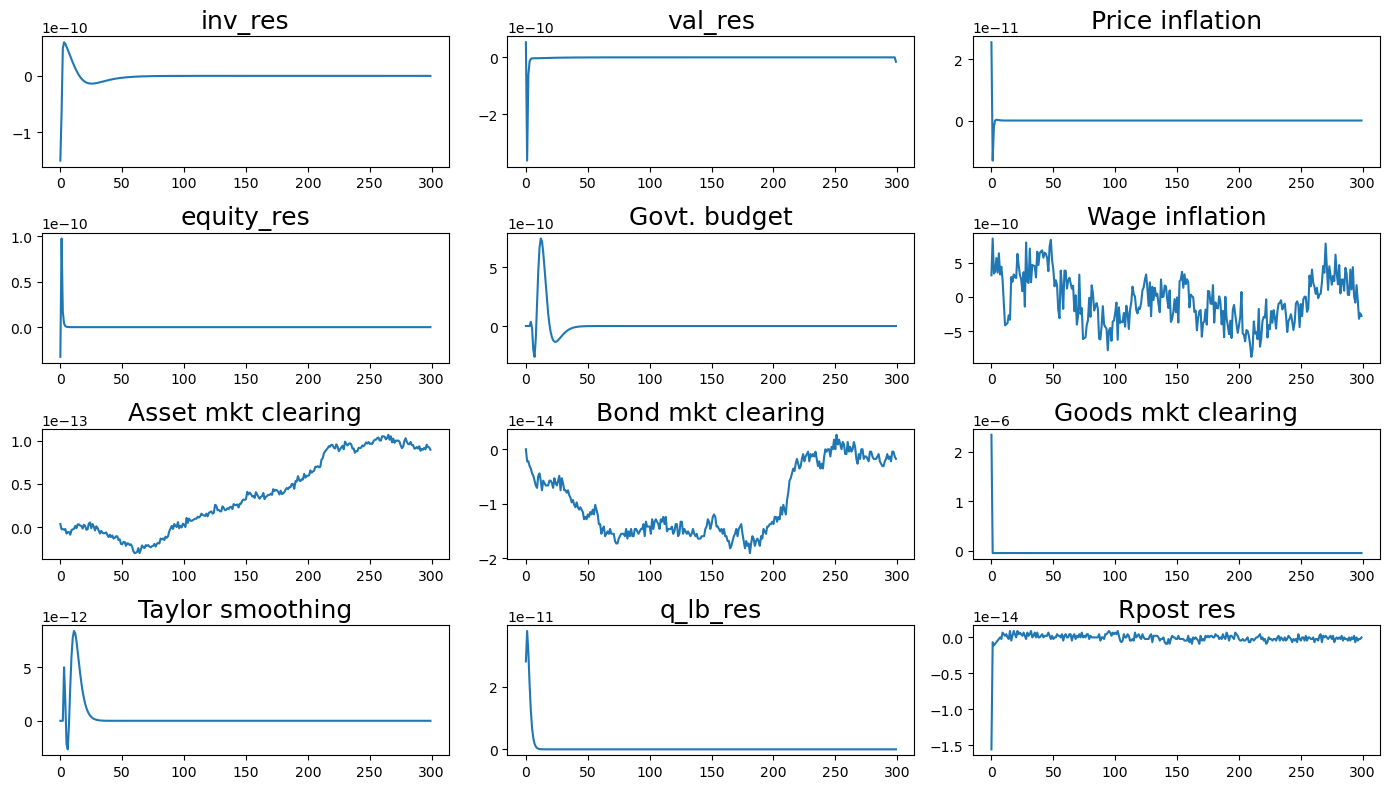

In [4]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r, hank_lb_residuals)

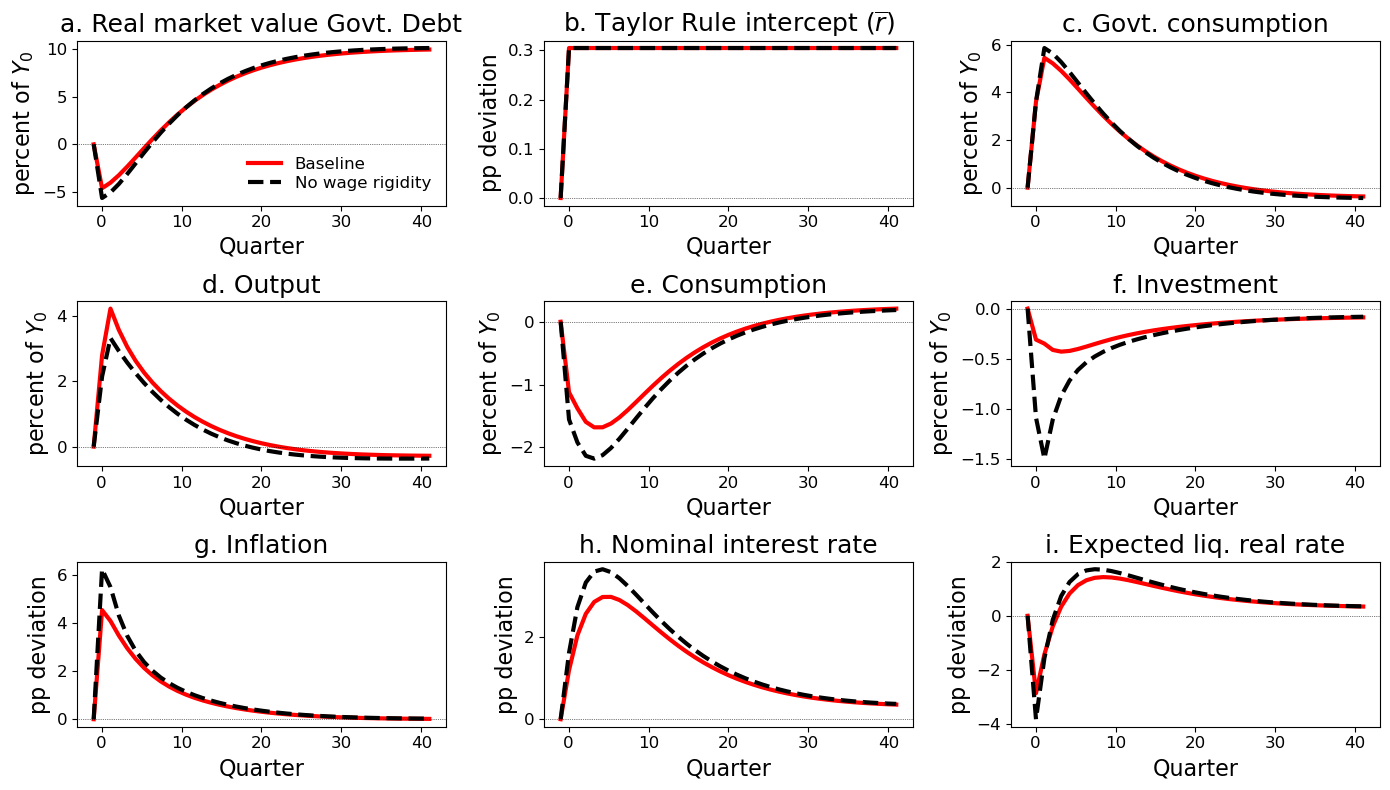

In [5]:
# Figure 10 in the Appendix

irf_hank_lb_nowager = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_lb_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'No wage rigidity': irf_hank_lb_nowager}
plot_cases = ['Baseline', 'No wage rigidity']
save_name = os.path.join("results", "HANK_2_baseline_nowagerig.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

## Short bonds

In [6]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_sb.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_sb.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
fisher_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
fisher_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt:

In [7]:
ss_hank_ini['fisher_res'] = 0.0
ss_hank_end['fisher_res'] = 0.0

T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'fisher_res', 'bond_mkt']

hank_sb.solve_impulse_nonlinear_options['maxit'] = 100
hank_sb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_sb_r =  hank_sb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with short bonds for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'fisher_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
  

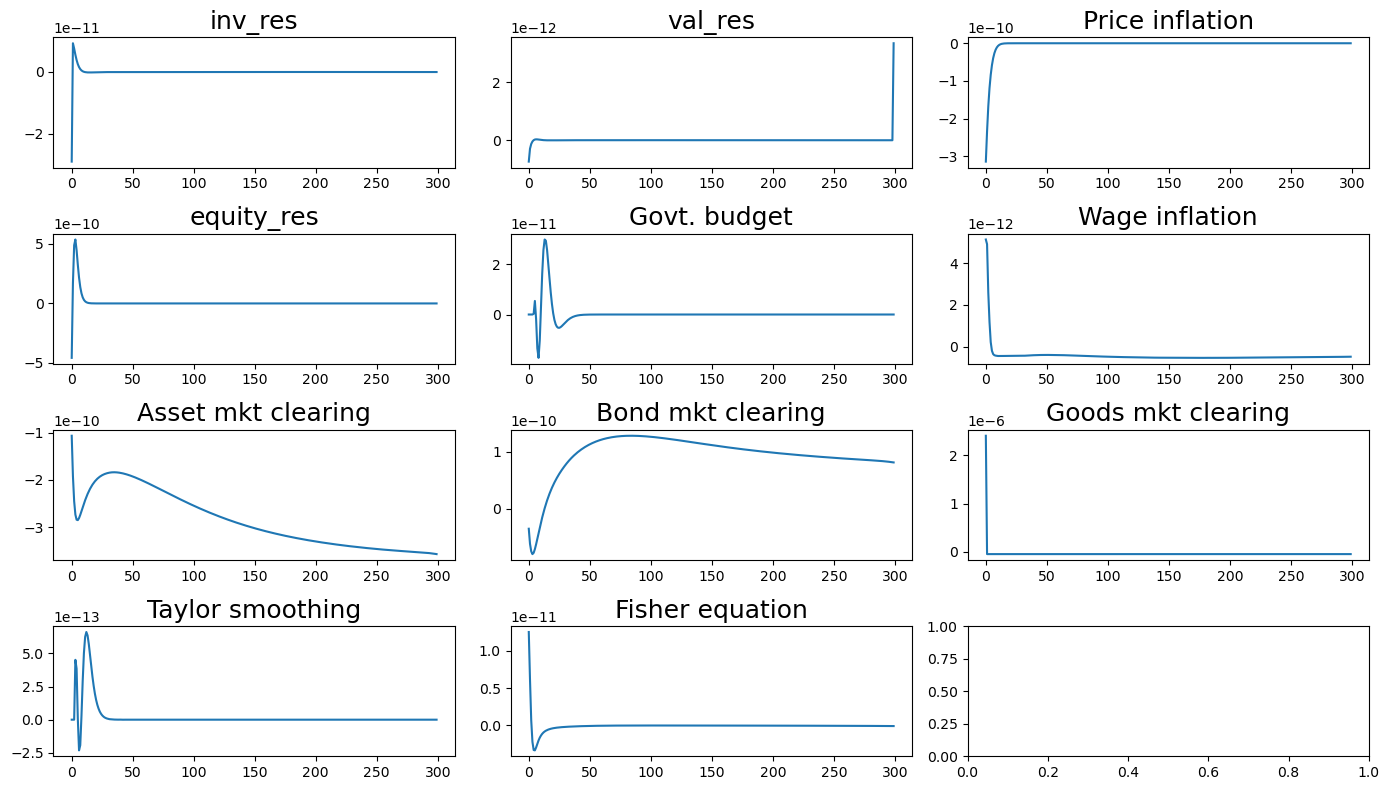

In [8]:
hank_sb_residuals = [k for k in hank_sb.outputs if is_residual(k)]
plot_residuals(irf_hank_sb_r, hank_sb_residuals)

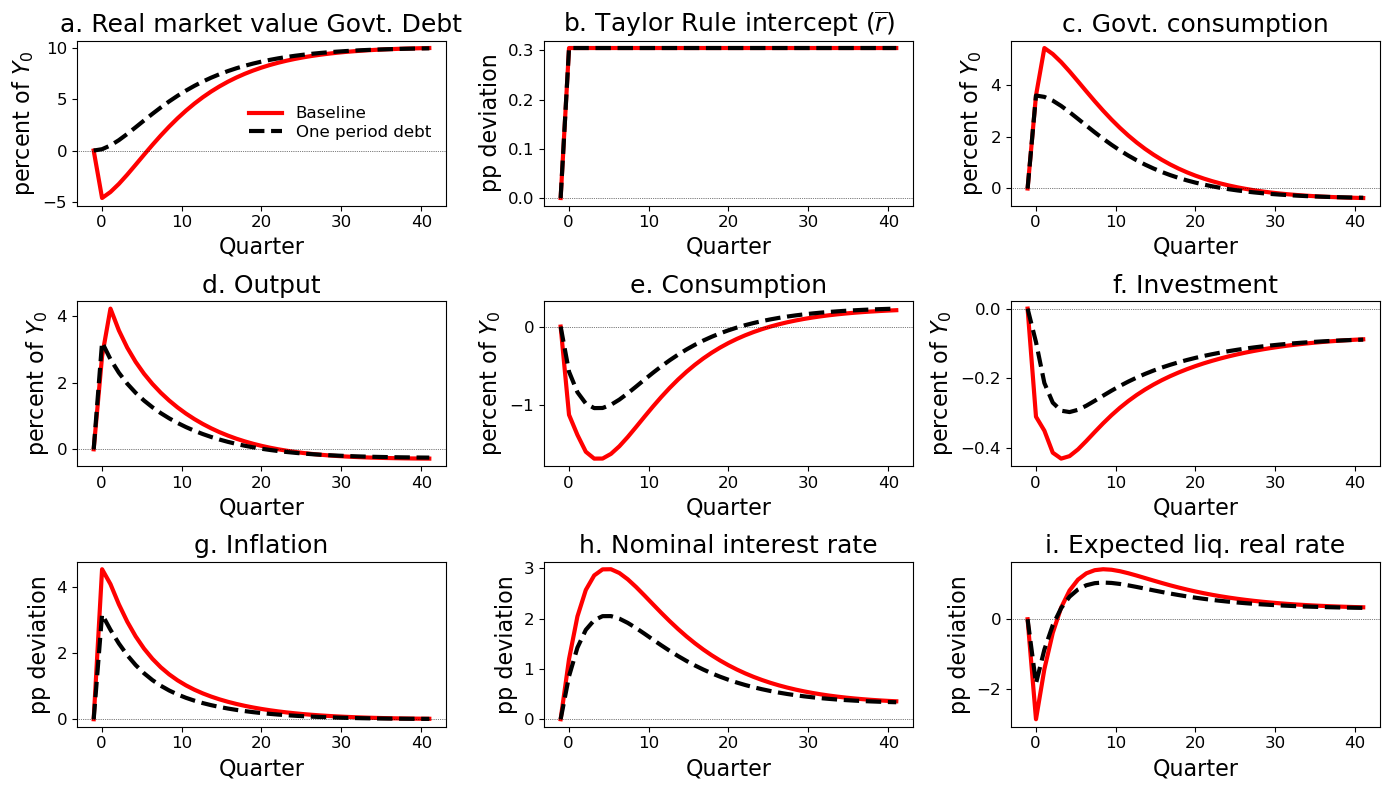

In [9]:
# Figure 12 in the Appendix

irf_hank_sb = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_sb_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'One period debt': irf_hank_sb}
plot_cases = ['Baseline', 'One period debt']
save_name = os.path.join("results", "HANK_2assets_Longbonds_VS_Shortbonds.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

## Alternative distribution of dividends

In [10]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_np.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_np.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.0

In [11]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_np.solve_impulse_nonlinear_options['maxit'] = 100
hank_np.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_np_r = hank_np.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, shocks_rebased, ss_initial=ss_hank_ini)

Solving Two-Asset HANK without extra profits for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 

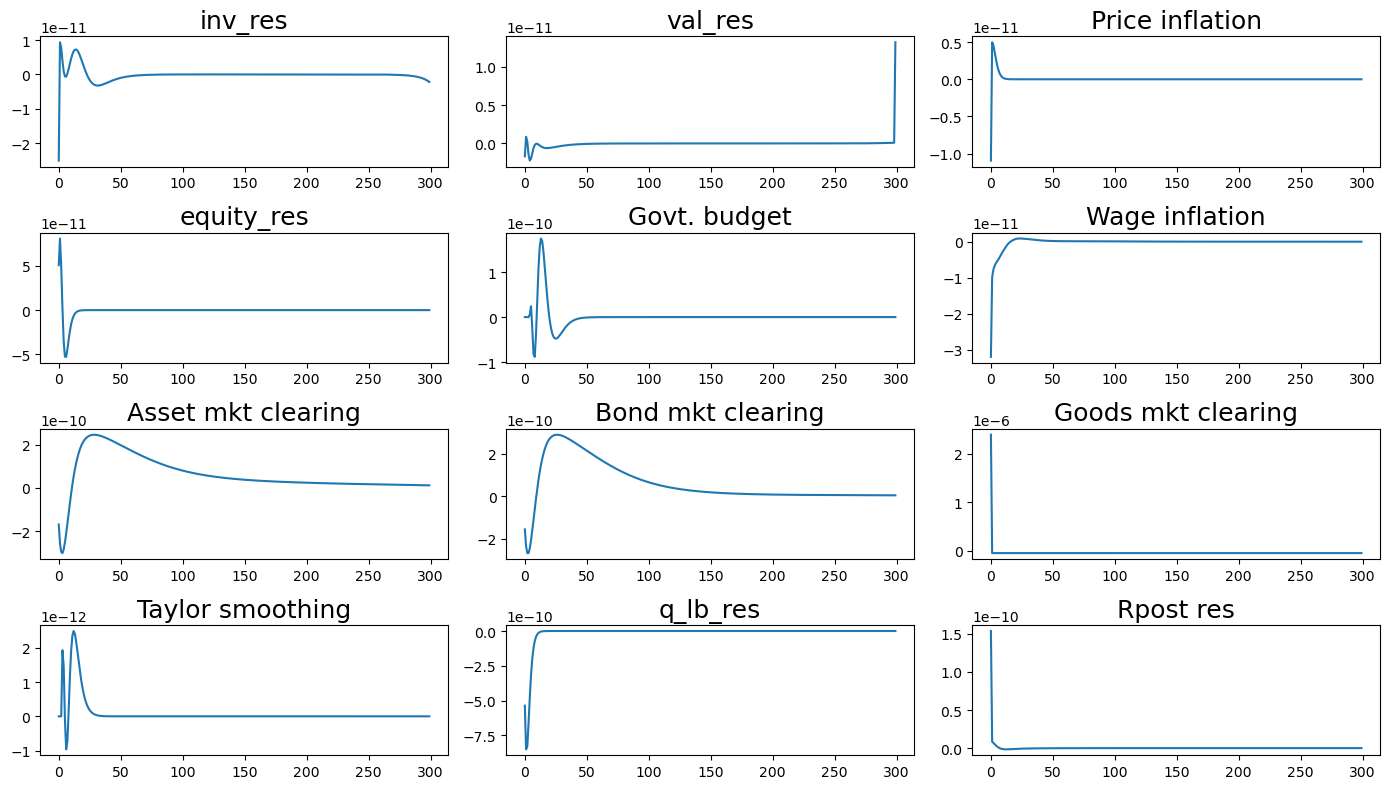

In [12]:
hank_np_residuals = [k for k in hank_np.outputs if is_residual(k)]
plot_residuals(irf_hank_np_r, hank_np_residuals)

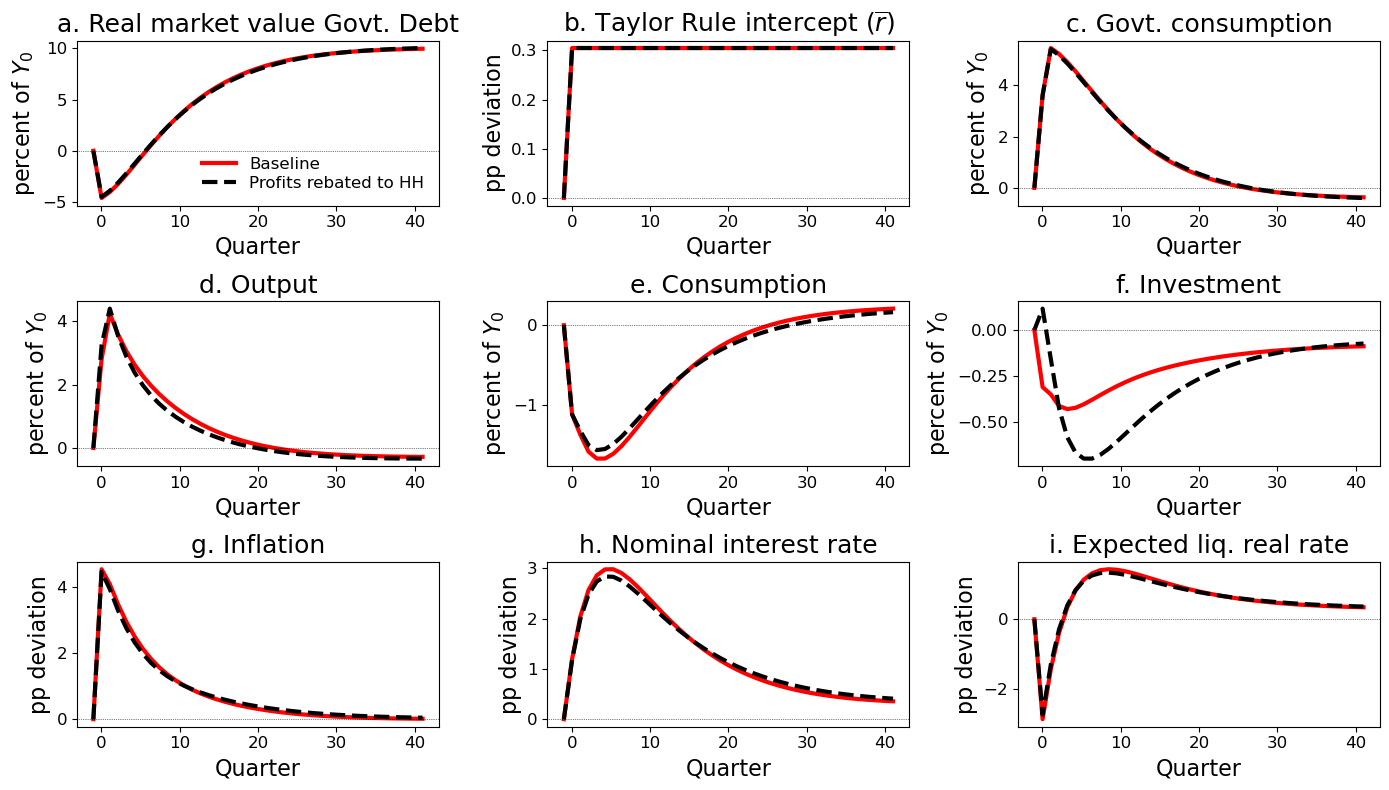

In [13]:
# Figure 13 in the Appendix

irf_hank_np = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_np_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, 'Profits rebated to HH': irf_hank_np}
plot_cases = ['Baseline', 'Profits rebated to HH']
save_name = os.path.join("results", "robustness_investment_GE.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'rbar', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)


## Holden's rule

In [14]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_hr.steady_state(data, dissolve=['G_rule'])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_hr.steady_state(data, dissolve=['G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_

In [15]:
T = 300

dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_hr.solve_impulse_nonlinear_options['maxit'] = 100
hank_hr.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_hr_r = hank_hr.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, shocks_rebased, ss_initial=ss_hank_ini)

Solving Baseline Two-Asset HANK with Holden's rule for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving q_lb_inner for ['Q_lb'] to hit ['q_lb_res']
On iterati

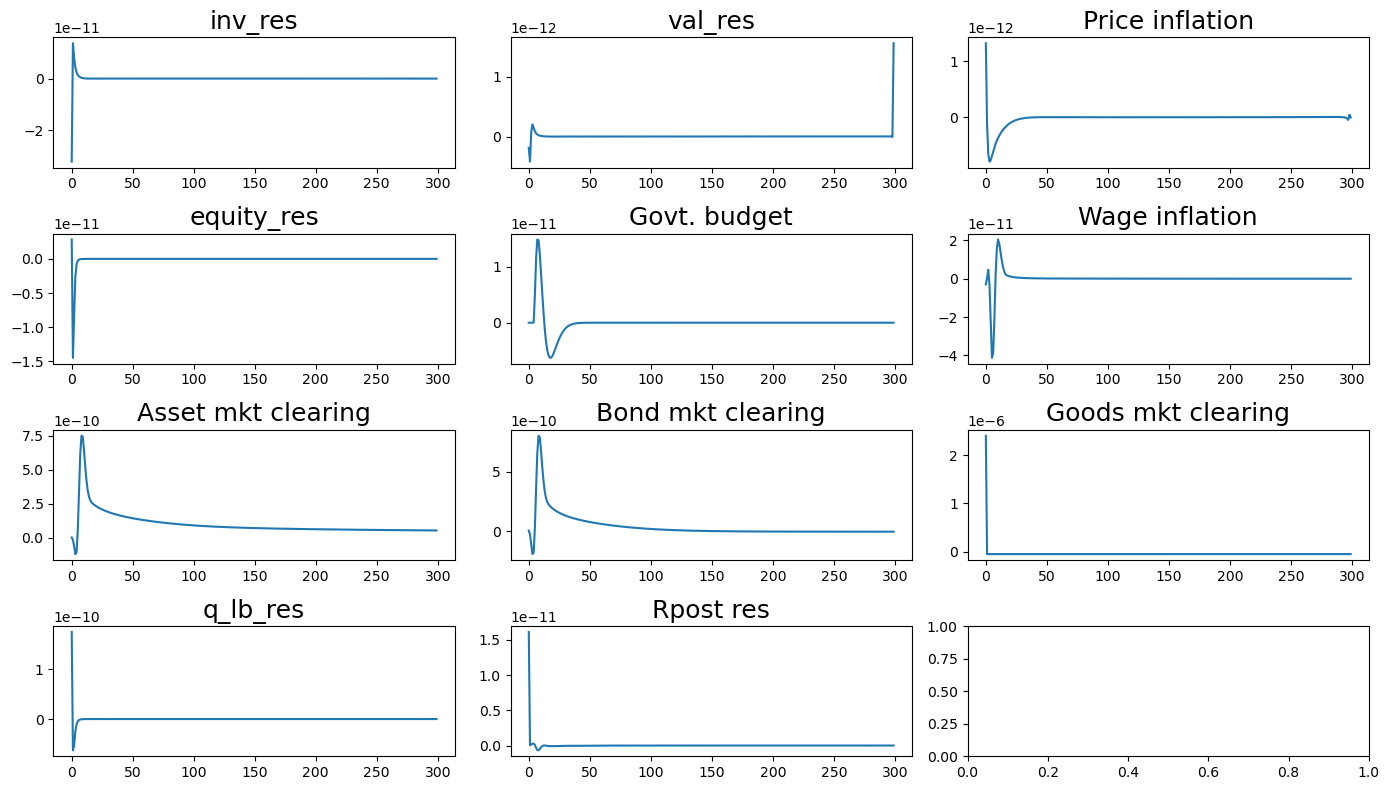

In [16]:
hank_hr_residuals = [k for k in hank_hr.outputs if is_residual(k)]
plot_residuals(irf_hank_hr_r, hank_hr_residuals)

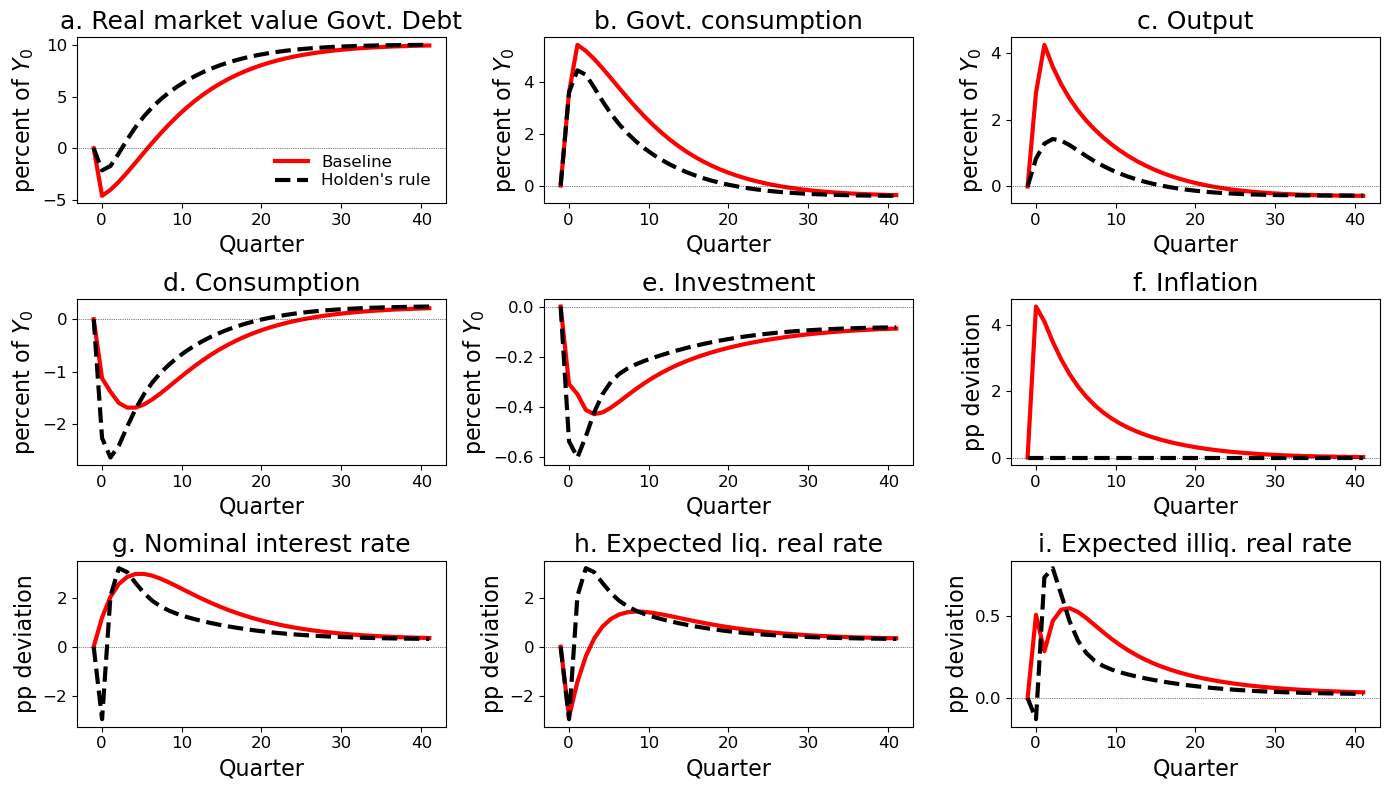

In [17]:
# Figure 16 in the Appendix

irf_hank_hr = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_hr_r)

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

to_plot = {'Baseline': irf_baseline, "Holden's rule": irf_hank_hr}
plot_cases = ['Baseline', "Holden's rule"]
save_name = os.path.join("results", "Holden_2.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e', 'ra_e'], ncols=3)